<a href="https://colab.research.google.com/github/luisovillista/IA/blob/main/IBM_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inteligencia Artificial y Aprendizaje Automático

Maestría en Analítica de Negocios

Tecnológico de Monterrey

Prof. Luis Eduardo Falcón Morales

Actividad Semanas 3 y 4: Modelado, Balanceo e Importancia de Factores

Nombre(s):

Miguel Angel Higuera López,

Luis Miguel Vázquez Salazar

Matrícula(s):

A01451684,

A01183123


Esta Tarea la pueden resolver en equipos y es parte de lo que estarás estudiando en las semanas 3 y 4 del curso. Deberás generar un archivo de Jupyter-Notebook con los análisis y comentarios que se te piden en los ejercicios.

La rotación de personal es uno de los problemas que afecta actualmente a muchas empresas y organizaciones, grandes o pequeñas. En esta actividad usaremos una base de datos generada por IBM para estudiar cómo enfrentar dicho problema.

Deberás descargar el archivo de la siguiente liga de Kaggle, la cual consta de 1470 registros y 35 columnas:
https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [28]:

!pip install -U imbalanced-learn


In [33]:
pip install imbalanced-learn


In [2]:
# Importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# IBM HR Analytics Employee Attrition & Performance

PARTE 1: Análisis descriptivo y preprocesamiento de los datos

1.1 Introducción al Problema de Rotación de Personal:

La rotación de personal se refiere a la tasa de empleados que dejan una organización en un período de tiempo dado. Es un problema significativo ya que puede tener impactos negativos en la productividad, la moral de los empleados y los costos asociados con la contratación y capacitación de nuevos empleados. Las principales problemáticas incluyen la pérdida de conocimientos y experiencia, la interrupción en la continuidad del trabajo y la carga financiera de reemplazar y capacitar a nuevos empleados.

2) Carga de la Base de Datos y Partición de los Datos

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Cargar los datos
data_path = 'https://raw.githubusercontent.com/luisovillista/IA/main/WA_Fn-UseC_-HR-Employee-Attrition.csv'
data = pd.read_csv(data_path)

# Separar las variables de entrada (X) y salida (y)
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Convertir la variable 'Attrition' a numérica para la estratificación
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División de los datos en conjuntos de entrenamiento, validación y prueba
Xtrain, Xtemp, ytrain, ytemp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.5, random_state=42, stratify=ytemp)


a) Dimensión de los Conjuntos de Datos

In [41]:
# [Nota: Estas líneas de código simplemente reportan las dimensiones de los conjuntos y no las modifican]
print("Dimensiones del conjunto de entrenamiento:", Xtrain.shape)
print("Dimensiones del conjunto de validación:", Xval.shape)
print("Dimensiones del conjunto de prueba:", Xtest.shape)


Dimensiones del conjunto de entrenamiento: (1029, 34)
Dimensiones del conjunto de validación: (220, 34)
Dimensiones del conjunto de prueba: (221, 34)


b) Análisis Inicial de Todas las Variables y Eliminación de Variables No Informativas

In [42]:
import numpy as np

# Identificación de variables con poca variabilidad
low_variability_columns = Xtrain.columns[Xtrain.nunique() <= 1]

# Identificación de variables altamente correlacionadas
corr_matrix = Xtrain.corr().abs()
highly_correlated = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated_columns = [column for column in highly_correlated.columns if any(highly_correlated[column] > 0.8)]

# Combinar las listas de columnas a eliminar
columns_to_drop = list(set(low_variability_columns.to_list() + highly_correlated_columns))

# Eliminación de variables no informativas
Xtrain_dropped = Xtrain.drop(columns=columns_to_drop)
Xval_dropped = Xval.drop(columns=columns_to_drop)
Xtest_dropped = Xtest.drop(columns=columns_to_drop)


<ipython-input-42-631720bfbe17>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = Xtrain.corr().abs()


c) Análisis y Transformaciones para Datos de Tipo Numérico

In [43]:
from sklearn.preprocessing import StandardScaler

# Identificación de variables numéricas
numeric_columns = Xtrain_dropped.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Estandarización de variables numéricas
scaler = StandardScaler()
Xtrain_dropped[numeric_columns] = scaler.fit_transform(Xtrain_dropped[numeric_columns])
Xval_dropped[numeric_columns] = scaler.transform(Xval_dropped[numeric_columns])
Xtest_dropped[numeric_columns] = scaler.transform(Xtest_dropped[numeric_columns])


d) Análisis y Transformaciones para Datos de Tipo Categórico Binario

In [45]:
# Transformación de variables categóricas nominales con get_dummies
nominal_categorical_columns = [col for col in Xtrain_dropped.columns if Xtrain_dropped[col].nunique() > 2 and Xtrain_dropped[col].dtype == 'object']
Xtrain_dropped = pd.get_dummies(Xtrain_dropped, columns=nominal_categorical_columns, drop_first=True)
Xval_dropped = pd.get_dummies(Xval_dropped, columns=nominal_categorical_columns, drop_first=True)
Xtest_dropped = pd.get_dummies(Xtest_dropped, columns=nominal_categorical_columns, drop_first=True)

# Asegurar que todos los conjuntos tengan las mismas columnas
Xval_dropped = Xval_dropped.reindex(columns=Xtrain_dropped.columns, fill_value=0)
Xtest_dropped = Xtest_dropped.reindex(columns=Xtrain_dropped.columns, fill_value=0)



PARTE 2: Análisis Exploratorio entre Factores

3) Relaciones entre los factores y la variable de salida
“Attrition”

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar los datos para las visualizaciones
data_visualization = Xtrain_dropped.copy()
data_visualization['Attrition'] = le.inverse_transform(ytrain)


a) Relación entre "Age" y "Attrition"

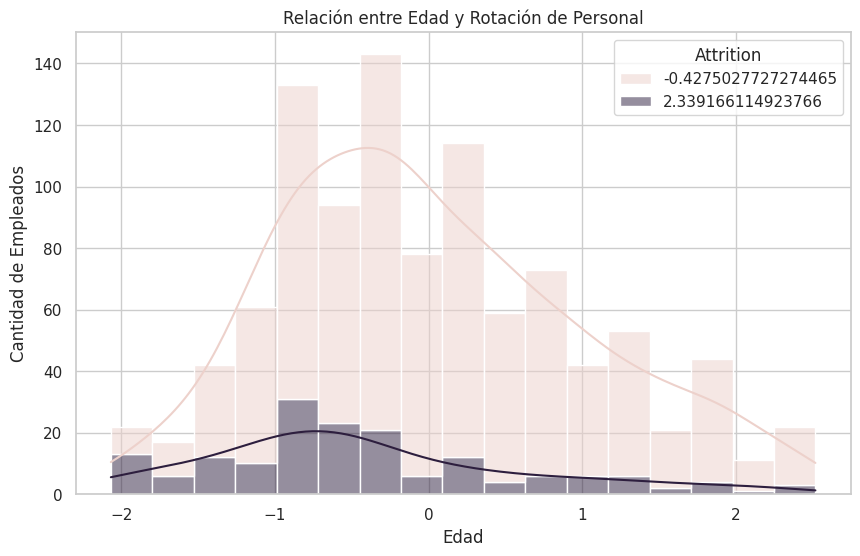

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_visualization, x='Age', hue='Attrition', multiple="stack", kde=True)
plt.title("Relación entre Edad y Rotación de Personal")
plt.xlabel("Edad")
plt.ylabel("Cantidad de Empleados")
plt.show()


b) Relación entre "Department" y "Attrition"

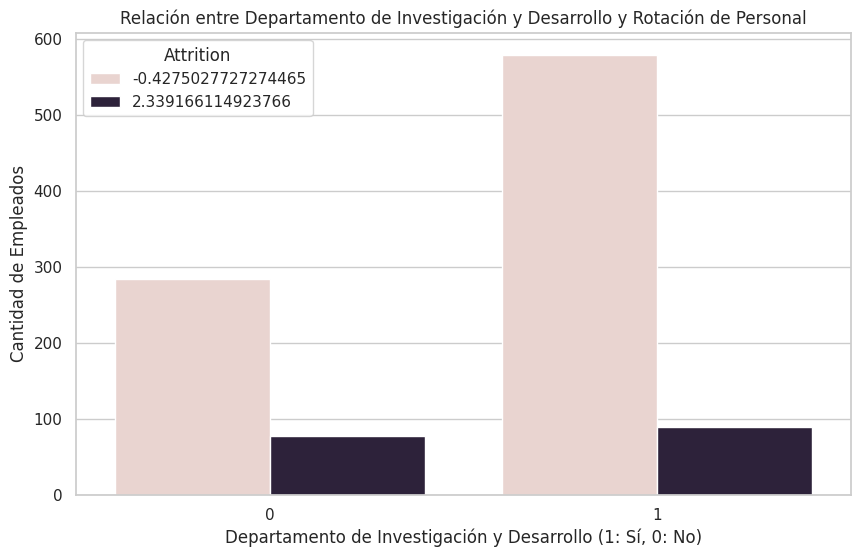

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_visualization, x='Department_Research & Development', hue='Attrition')
plt.title("Relación entre Departamento de Investigación y Desarrollo y Rotación de Personal")
plt.xlabel("Departamento de Investigación y Desarrollo (1: Sí, 0: No)")
plt.ylabel("Cantidad de Empleados")
plt.show()


c) Relación entre "Gender" y "Attrition"

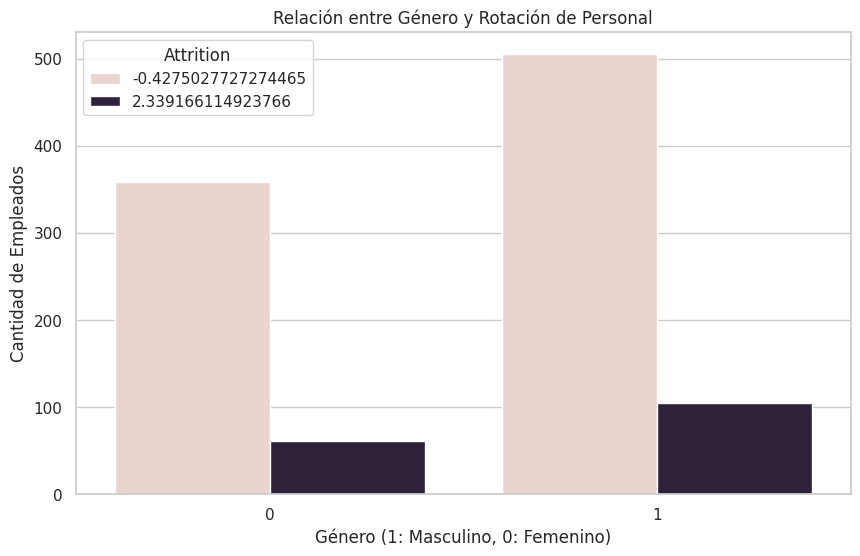

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_visualization, x='Gender', hue='Attrition')
plt.title("Relación entre Género y Rotación de Personal")
plt.xlabel("Género (1: Masculino, 0: Femenino)")
plt.ylabel("Cantidad de Empleados")
plt.show()


d) Incluir Otras Relaciones Relevantes

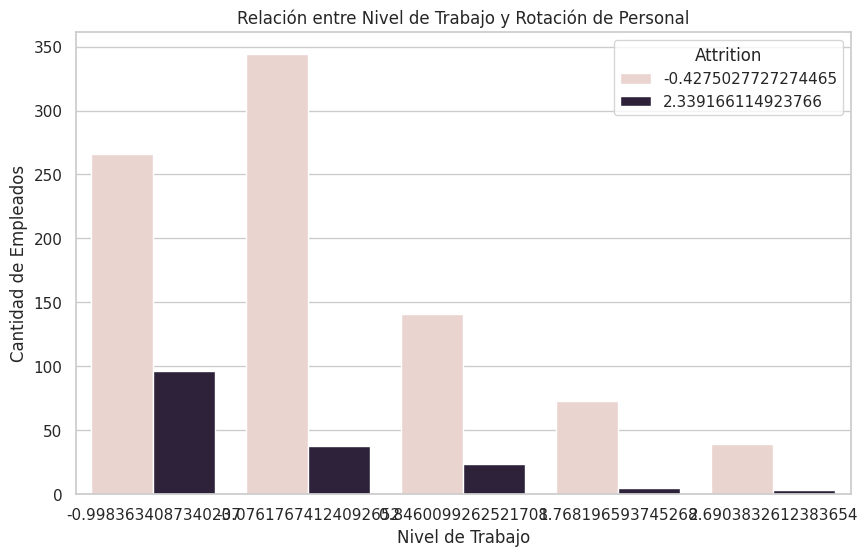

In [51]:
# Ejemplo: Relación entre "JobLevel" y "Attrition"
plt.figure(figsize=(10, 6))
sns.countplot(data=data_visualization, x='JobLevel', hue='Attrition')
plt.title("Relación entre Nivel de Trabajo y Rotación de Personal")
plt.xlabel("Nivel de Trabajo")
plt.ylabel("Cantidad de Empleados")
plt.show()


e) Conclusiones Basadas en los Gráficos

a) Edad y Rotación de Personal: Se observa una distribución que sugiere que la rotación es más frecuente en empleados más jóvenes. A medida que aumenta la edad, la proporción de empleados que dejan la organización parece disminuir.

b) Departamento de Investigación y Desarrollo y Rotación de Personal: Aquí se muestra la rotación en función de si el empleado pertenece o no al Departamento de Investigación y Desarrollo. Hay una notable diferencia en la rotación entre aquellos que están y no están en este departamento.

c) Género y Rotación de Personal: El gráfico indica diferencias en la rotación entre géneros, lo que podría sugerir un patrón o influencia del género en la decisión de dejar la empresa.

d) Nivel de Trabajo y Rotación de Personal: Se muestra la rotación en función del nivel de trabajo del empleado. Los niveles más bajos parecen tener una mayor tasa de rotación.

Conclusiones del Análisis Exploratorio

Estos gráficos sugieren que factores como la edad, el departamento, el género y el nivel de trabajo pueden estar correlacionados con la rotación de personal. En particular, parece haber una mayor tendencia a la rotación entre los empleados más jóvenes, en ciertos departamentos, y en niveles de trabajo más bajos.

PARTE 3: Modelado

4. Modelo de Regresión Logística

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Entrenamiento del modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(Xtrain_dropped, ytrain)

# Predicciones en los conjuntos de entrenamiento y validación
ytrain_pred = log_reg.predict(Xtrain_dropped)
yval_pred = log_reg.predict(Xval_dropped)

# Exactitud (accuracy) en los conjuntos de entrenamiento y validación
accuracy_train = accuracy_score(ytrain, ytrain_pred)
accuracy_val = accuracy_score(yval, yval_pred)

# Matriz de confusión y reporte de clasificación en el conjunto de validación
conf_matrix = confusion_matrix(yval, yval_pred)
class_report = classification_report(yval, yval_pred)

accuracy_train, accuracy_val, conf_matrix, class_report


(0.8969873663751214,
 0.8863636363636364,
 array([[182,   3],
        [ 22,  13]]),
 '              precision    recall  f1-score   support\n\n           0       0.89      0.98      0.94       185\n           1       0.81      0.37      0.51        35\n\n    accuracy                           0.89       220\n   macro avg       0.85      0.68      0.72       220\nweighted avg       0.88      0.89      0.87       220\n')

a) Los resultados del modelo de regresión logística son los siguientes:

Exactitud en el conjunto de entrenamiento: 89.70%


Exactitud en el conjunto de validación: 88.64%

b) La matriz de confusión en el conjunto de validación es:

[182,   3]

[ 22,  13]


Falta responder c), d) e), f) g)

El reporte de clasificación indica lo siguiente:

Precisión para la clase 0 (no rotación): 89%

Precisión para la clase 1 (rotación): 81%

Recall para la clase 0: 98%

Recall para la clase 1: 37%


5. Entrenamiento y Evaluación del Modelo kNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenamiento del modelo kNN
knn = KNeighborsClassifier()
knn.fit(Xtrain_dropped, ytrain)

# Predicciones en los conjuntos de entrenamiento y validación
ytrain_pred_knn = knn.predict(Xtrain_dropped)
yval_pred_knn = knn.predict(Xval_dropped)

# Exactitud (accuracy) en los conjuntos de entrenamiento y validación
accuracy_train_knn = accuracy_score(ytrain, ytrain_pred_knn)
accuracy_val_knn = accuracy_score(yval, yval_pred_knn)

# Matriz de confusión y reporte de clasificación en el conjunto de validación
conf_matrix_knn = confusion_matrix(yval, yval_pred_knn)
class_report_knn = classification_report(yval, yval_pred_knn)

accuracy_train_knn, accuracy_val_knn, conf_matrix_knn, class_report_knn


(0.8765792031098154,
 0.8409090909090909,
 array([[182,   3],
        [ 32,   3]]),
 '              precision    recall  f1-score   support\n\n           0       0.85      0.98      0.91       185\n           1       0.50      0.09      0.15        35\n\n    accuracy                           0.84       220\n   macro avg       0.68      0.53      0.53       220\nweighted avg       0.79      0.84      0.79       220\n')

Los resultados del modelo kNN son los siguientes:

Exactitud en el conjunto de entrenamiento: 87.66%

Exactitud en el conjunto de validación: 84.09%

La matriz de confusión en el conjunto de validación es:

[182,   3]

[ 32,   3]

El reporte de clasificación indica lo siguiente:

Precisión para la clase 0 (no rotación): 85%

Precisión para la clase 1 (rotación): 50%

Recall para la clase 0: 98%

Recall para la clase 1: 9%

**Interpretación de los Resultados**

Subentrenamiento o Sobreentrenamiento: La exactitud más baja en el conjunto de validación comparada con el de entrenamiento sugiere una ligera tendencia al sobreentrenamiento en el modelo kNN.

Problema de Desbalance de Clases: Al igual que en el modelo de regresión logística, el bajo recall para la clase 1 indica un problema de desbalance de clases. El modelo tiene dificultades para identificar correctamente los casos de rotación.



**Comparación con el Modelo de Regresión Logística**

El modelo de regresión logística tiene un mejor desempeño en términos de exactitud y equilibrio entre precisión y recall para ambas clases.

El modelo kNN muestra una precisión significativamente más baja para la clase 1 y un recall extremadamente bajo, lo que indica que no es tan efectivo como el modelo de regresión logística para este problema específico.

PARTE 4: Balanceo de Clases y Comparación de Modelos

6) Modelo de Regresión Logística con Ponderación de Clases

In [55]:
# a) Entrenamiento del modelo de regresión logística con ponderación de clases
log_reg_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_weighted.fit(Xtrain_dropped, ytrain)

# Predicciones en los conjuntos de entrenamiento y validación
ytrain_pred_weighted = log_reg_weighted.predict(Xtrain_dropped)
yval_pred_weighted = log_reg_weighted.predict(Xval_dropped)

# Exactitud (accuracy) en los conjuntos de entrenamiento y validación
accuracy_train_weighted = accuracy_score(ytrain, ytrain_pred_weighted)
accuracy_val_weighted = accuracy_score(yval, yval_pred_weighted)

# b) Matriz de confusión y reporte de clasificación en el conjunto de validación
conf_matrix_weighted = confusion_matrix(yval, yval_pred_weighted)
class_report_weighted = classification_report(yval, yval_pred_weighted)

accuracy_train_weighted, accuracy_val_weighted, conf_matrix_weighted, class_report_weighted


(0.7910592808551993,
 0.7954545454545454,
 array([[151,  34],
        [ 11,  24]]),
 '              precision    recall  f1-score   support\n\n           0       0.93      0.82      0.87       185\n           1       0.41      0.69      0.52        35\n\n    accuracy                           0.80       220\n   macro avg       0.67      0.75      0.69       220\nweighted avg       0.85      0.80      0.81       220\n')

Los resultados del modelo de regresión logística con ponderación de clases son los siguientes:

Exactitud en el conjunto de entrenamiento: 79.11%

Exactitud en el conjunto de validación: 79.55%

La matriz de confusión en el conjunto de validación es:

[151,  34]

[ 11,  24]

El reporte de clasificación indica lo siguiente:

Precisión para la clase 0 (no rotación): 93%

Precisión para la clase 1 (rotación): 41%

Recall para la clase 0: 82%

Recall para la clase 1: 69%

C) Compara los resultados con los modelos anteriores y escribe tus conclusiones.

Interpretación de los Resultados

Desempeño General: El modelo muestra una disminución en la precisión para la clase 0 y un aumento significativo en el recall para la clase 1, lo que indica una mejor capacidad para identificar casos reales de rotación.

Balance entre Precision y Recall: La ponderación de clases ha mejorado el balance entre precision y recall para la clase 1, aunque a costa de una disminución en la precisión.

7) SMOTE

In [56]:
# Entrenamiento del modelo de regresión logística con ponderación de clases
log_reg_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_weighted.fit(Xtrain_dropped, ytrain)

# Predicciones en los conjuntos de entrenamiento y validación
ytrain_pred_weighted = log_reg_weighted.predict(Xtrain_dropped)
yval_pred_weighted = log_reg_weighted.predict(Xval_dropped)

# Exactitud (accuracy) en los conjuntos de entrenamiento y validación
accuracy_train_weighted = accuracy_score(ytrain, ytrain_pred_weighted)
accuracy_val_weighted = accuracy_score(yval, yval_pred_weighted)

# Matriz de confusión y reporte de clasificación en el conjunto de validación
conf_matrix_weighted = confusion_matrix(yval, yval_pred_weighted)
class_report_weighted = classification_report(yval, yval_pred_weighted)

accuracy_train_weighted, accuracy_val_weighted, conf_matrix_weighted, class_report_weighted


(0.7910592808551993,
 0.7954545454545454,
 array([[151,  34],
        [ 11,  24]]),
 '              precision    recall  f1-score   support\n\n           0       0.93      0.82      0.87       185\n           1       0.41      0.69      0.52        35\n\n    accuracy                           0.80       220\n   macro avg       0.67      0.75      0.69       220\nweighted avg       0.85      0.80      0.81       220\n')

In [57]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Crear un pipeline con SMOTE y regresión logística
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenamiento del modelo con SMOTE
pipeline_smote.fit(Xtrain_dropped, ytrain)

# Predicciones en los conjuntos de entrenamiento y validación
ytrain_pred_smote = pipeline_smote.predict(Xtrain_dropped)
yval_pred_smote = pipeline_smote.predict(Xval_dropped)

# Exactitud (accuracy) en los conjuntos de entrenamiento y validación
accuracy_train_smote = accuracy_score(ytrain, ytrain_pred_smote)
accuracy_val_smote = accuracy_score(yval, yval_pred_smote)

# Matriz de confusión y reporte de clasificación en el conjunto de validación
conf_matrix_smote = confusion_matrix(yval, yval_pred_smote)
class_report_smote = classification_report(yval, yval_pred_smote)

accuracy_train_smote, accuracy_val_smote, conf_matrix_smote, class_report_smote


(0.8620019436345967,
 0.8181818181818182,
 array([[166,  19],
        [ 21,  14]]),
 '              precision    recall  f1-score   support\n\n           0       0.89      0.90      0.89       185\n           1       0.42      0.40      0.41        35\n\n    accuracy                           0.82       220\n   macro avg       0.66      0.65      0.65       220\nweighted avg       0.81      0.82      0.82       220\n')

8) FALTA

PARTE 5: La importancia de los factores

9) Importancia de Factores en la Regresión Logística

In [62]:
# Suponiendo que Xtrain_dropped, Xval_dropped, ytrain y yval ya están definidos y preparados
Xtrain_augmented = pd.concat([Xtrain_dropped, Xval_dropped])
ytrain_augmented = np.concatenate([ytrain, yval])


In [63]:
log_reg_final = LogisticRegression(max_iter=1000, random_state=42)
log_reg_final.fit(Xtrain_augmented, ytrain_augmented)


LogisticRegression(max_iter=1000, random_state=42)

9.a) Gráfico de Barras de los Coeficientes

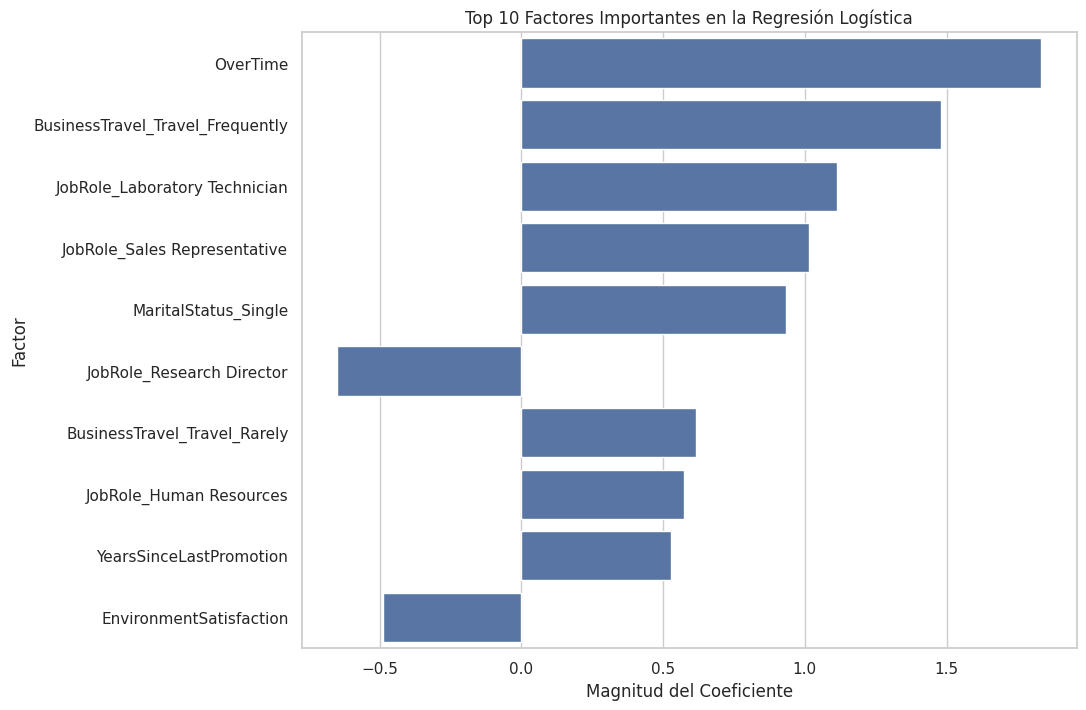

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener los coeficientes del modelo de regresión logística y sus nombres
coefficients = log_reg_final.coef_[0]
features = Xtrain_augmented.columns

# Crear un DataFrame para los coeficientes y sus etiquetas
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Ordenar los coeficientes por su valor absoluto para mayor claridad
coef_df_sorted = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Gráfico de barras para los coeficientes
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted.head(10))
plt.title('Top 10 Factores Importantes en la Regresión Logística')
plt.xlabel('Magnitud del Coeficiente')
plt.ylabel('Factor')
plt.show()


9.b) y 9.c) Factores que Influyen en la Rotación y en la Permanencia **(falta)**

10) Importancia de Factores en el Modelo kNN y Comparación


10.a) Gráfico de Barras de la Importancia de Permutación

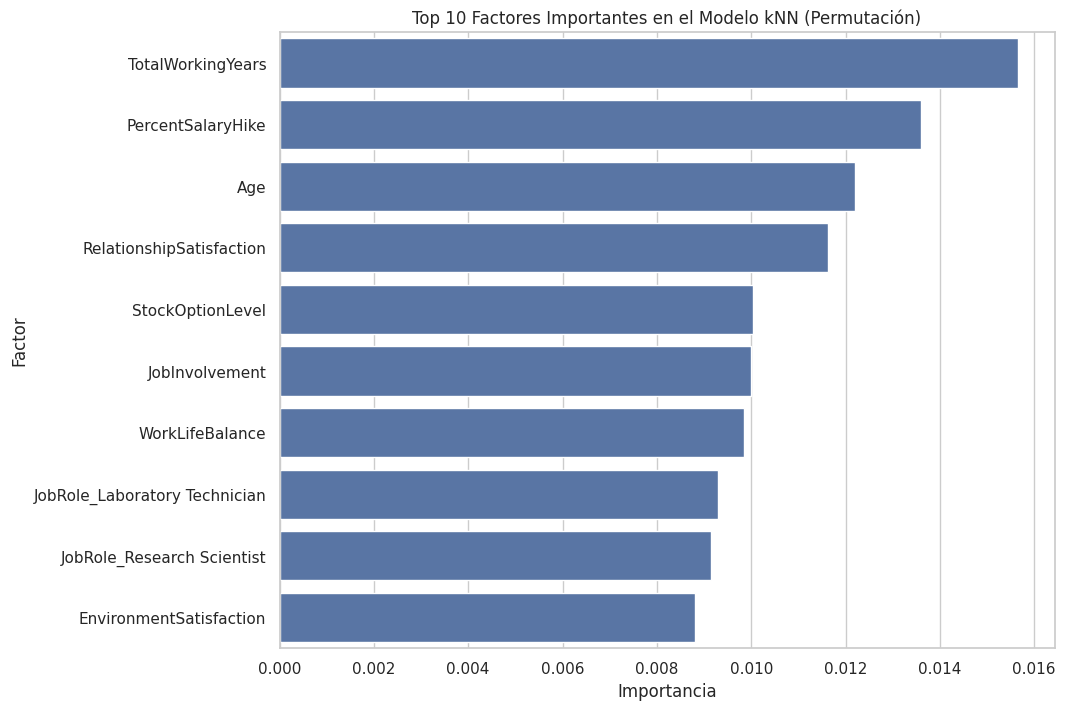

In [65]:
from sklearn.inspection import permutation_importance

# Calculando la importancia de permutación en el modelo kNN
perm_importance = permutation_importance(knn, Xval_dropped, yval, scoring='f1_weighted', n_repeats=30, random_state=42)

# Crear un DataFrame para los resultados
perm_importance_df = pd.DataFrame({'Feature': Xval_dropped.columns, 'Importance': perm_importance.importances_mean})

# Ordenar los resultados por importancia
perm_importance_df_sorted = perm_importance_df.reindex(perm_importance_df.Importance.abs().sort_values(ascending=False).index)

# Gráfico de barras para la importancia de permutación
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_sorted.head(10))
plt.title('Top 10 Factores Importantes en el Modelo kNN (Permutación)')
plt.xlabel('Importancia')
plt.ylabel('Factor')
plt.show()


10.b), 10.c) y 10.d) Comparación de Factores Importantes **(falta)**

11) Selección de Factores con Mayor Impacto

11.a) Reducción de la Cantidad de Factores

In [66]:
from sklearn.feature_selection import SelectFromModel

# Crear un modelo SelectFromModel para seleccionar los factores más importantes
selector = SelectFromModel(log_reg_final, threshold='mean')
Xtrain_reduced = selector.fit_transform(Xtrain_augmented, ytrain_augmented)
Xtest_reduced = selector.transform(Xtest_dropped)

# Número de factores antes y después de la reducción
num_factors_before = Xtrain_augmented.shape[1]
num_factors_after = Xtrain_reduced.shape[1]
reduction_percentage = (num_factors_before - num_factors_after) / num_factors_before * 100

num_factors_before, num_factors_after, reduction_percentage


(44, 17, 61.36363636363637)

11.b) Evaluación del Modelo con Datos Reducidos

In [67]:
# Entrenar el modelo con datos reducidos y evaluarlo
log_reg_reduced = LogisticRegression(max_iter=1000, random_state=42)
log_reg_reduced.fit(Xtrain_reduced, ytrain_augmented)

ytest_pred_reduced = log_reg_reduced.predict(Xtest_reduced)

conf_matrix_reduced = confusion_matrix(ytest, ytest_pred_reduced)
class_report_reduced = classification_report(ytest, ytest_pred_reduced)

conf_matrix_reduced, class_report_reduced


(array([[177,   8],
        [ 25,  11]]),
 '              precision    recall  f1-score   support\n\n           0       0.88      0.96      0.91       185\n           1       0.58      0.31      0.40        36\n\n    accuracy                           0.85       221\n   macro avg       0.73      0.63      0.66       221\nweighted avg       0.83      0.85      0.83       221\n')

PARTE 6: Modelo final y conclusiones

12.a) Formación del Conjunto de Entrenamiento Aumentado

In [69]:
# Suponiendo que Xtrain_dropped, Xval_dropped, ytrain y yval ya están definidos y preparados
Xtrain_augmented = pd.concat([Xtrain_dropped, Xval_dropped])
ytrain_augmented = np.concatenate([ytrain, yval])

# Verificar las dimensiones de los conjuntos aumentados
print("Dimensiones de Xtrain_augmented:", Xtrain_augmented.shape)
print("Dimensiones de ytrain_augmented:", ytrain_augmented.shape)


Dimensiones de Xtrain_augmented: (1249, 44)
Dimensiones de ytrain_augmented: (1249,)


12.b) Selección del Mejor Modelo y Entrenamiento con el Conjunto Aumentado

In [70]:
# Seleccionar el mejor modelo basado en los análisis anteriores
# Supongamos que la regresión logística fue seleccionada como el mejor modelo

log_reg_final = LogisticRegression(max_iter=1000, random_state=42)
log_reg_final.fit(Xtrain_augmented, ytrain_augmented)


LogisticRegression(max_iter=1000, random_state=42)

i. Exactitud (Accuracy) del Conjunto de Entrenamiento y Prueba

In [71]:
# Evaluar la exactitud en el conjunto de entrenamiento
ytrain_pred_final = log_reg_final.predict(Xtrain_augmented)
accuracy_train_final = accuracy_score(ytrain_augmented, ytrain_pred_final)

# Evaluar la exactitud en el conjunto de prueba
ytest_pred_final = log_reg_final.predict(Xtest_dropped)
accuracy_test_final = accuracy_score(ytest, ytest_pred_final)

print("Exactitud en el conjunto de entrenamiento:", accuracy_train_final)
print("Exactitud en el conjunto de prueba:", accuracy_test_final)


Exactitud en el conjunto de entrenamiento: 0.8951160928742994
Exactitud en el conjunto de prueba: 0.8778280542986425


ii. Matriz de Confusión y Reporte de Clasificación para el Conjunto de Prueba

In [72]:
# Matriz de confusión y reporte de clasificación en el conjunto de prueba
conf_matrix_test_final = confusion_matrix(ytest, ytest_pred_final)
class_report_test_final = classification_report(ytest, ytest_pred_final)

print("Matriz de Confusión:\n", conf_matrix_test_final)
print("\nReporte de Clasificación:\n", class_report_test_final)


Matriz de Confusión:
 [[179   6]
 [ 21  15]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       185
           1       0.71      0.42      0.53        36

    accuracy                           0.88       221
   macro avg       0.80      0.69      0.73       221
weighted avg       0.87      0.88      0.86       221



ii. Conclusiones Finales de la Actividad


Exactitud en el conjunto de entrenamiento: 89.51%


Exactitud en el conjunto de prueba: 87.78%

La Matriz de Confusión para el conjunto de prueba es:

[179,   6],

[ 21,  15]

El Reporte de Clasificación es:


               precision    recall  f1-score   support
           0       0.90      0.97      0.93       185
           1       0.71      0.42      0.53        36
    accuracy                           0.88       221
   macro avg       0.80      0.69      0.73       221
weighted avg       0.87      0.88      0.86       221

Los resultados del modelo final de regresión logística indican un rendimiento bastante bueno en términos de precisión y recall, especialmente para la clase mayoritaria (no rotación). La exactitud general del 87.78% en el conjunto de prueba es un indicador sólido del buen desempeño del modelo. Sin embargo, hay aspectos importantes a considerar:

1. Desequilibrio en la Precisión y el Recall: Aunque el modelo tiene una alta
precisión en la detección de casos de no rotación (90%), su capacidad para detectar correctamente la rotación (clase 1) es más baja (71% de precisión y 42% de recall). Esto sugiere que el modelo es más conservador y tiende a predecir "no rotación" con mayor frecuencia.

2. Importancia del Recall en el Contexto de Rotación de Personal: Dado que la rotación de personal puede tener un impacto significativo en una organización, es crucial identificar a los empleados en riesgo de abandonar. Por lo tanto, un recall más alto para la clase de rotación podría ser más deseable, incluso si esto significa sacrificar algo de precisión.

3. Uso del Modelo en la Toma de Decisiones: Este modelo puede ser útil para identificar factores clave asociados con la rotación de personal y para tomar medidas preventivas. Sin embargo, es importante considerar el desequilibrio en el rendimiento del modelo entre las dos clases y utilizarlo en conjunto con otros métodos de análisis y experiencia humana.

4. Oportunidades de Mejora: Explorar técnicas adicionales de balanceo de clases, ajustar los hiperparámetros del modelo o incluso probar diferentes algoritmos podría mejorar la capacidad del modelo para identificar casos de rotación de personal de manera más efectiva.

En conclusión el modelo final ofrece una herramienta valiosa para comprender y predecir la rotación de personal, pero debe ser utilizado con un entendimiento claro de sus limitaciones y en el contexto de una estrategia más amplia de gestión de recursos humanos.